<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/report_quiz_french_to_english_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/French_to_English_machine_translation_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation using transformers: Overview

Transformers are a groundbreaking neural network architecture that has significantly advanced the field of natural language processing (NLP), particularly in sequence-to-sequence tasks. They've become the backbone of many modern NLP applications, including machine translation, text summarization, and language modeling.

A defining feature of transformers is their ability to process entire input sequences simultaneously. Unlike traditional recurrent models, which handle one token at a time, transformers leverage a self-attention mechanism to analyze relationships between all elements in a sequence at once. This enables the model to focus on relevant parts of the input context more efficiently and with greater flexibility.

In this tutorial, we'll explore how to build a machine translation system using the transformer architecture.



In [1]:
# import torch
# print(torch.__version__)
# print(torch.version.cuda)

In [2]:
# import numpy
# print(numpy.__version__)

In [3]:

# import torchdata
# print(torchdata.__version__)

In [4]:
# ✅ Install required packages with compatible versions for PyTorch-based English-to-French translation.
# Includes torch (with GPU support), torchtext for dataset utilities, spaCy for tokenization,
# and tqdm for progress visualization.


# Remove torchtune (if exist)
# !pip uninstall torchtune -y

# Reinstall compatible versions
!pip install torch==2.3.0 torchvision torchaudio
!pip install torchtext==0.18.0
!pip install 'portalocker>=2.0.0' --no-deps
# !pip install numpy==1.24.3


INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.

In [5]:
!pip install gputil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=a01d9d6c5e6ba4a65288589d495edca6cca6dfdd5ccc635353c9b50ab4801513
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil


In [6]:
# Confirm the torch version

import torch

torch.__version__

'2.3.0+cu121'

### Loading The Data

In [7]:
import torchtext

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


##### Download the dataset

In [8]:
# !pip install -U kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishreddy18/english-to-french")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'english-to-french' dataset.
Path to dataset files: /kaggle/input/english-to-french


In [10]:
english_path = '/kaggle/input/english-to-french/small_vocab_en.csv'
french_path = '/kaggle/input/english-to-french/small_vocab_fr.csv'

# english_path = '/root/.cache/kagglehub/datasets/harishreddy18/english-to-french/versions/1/small_vocab_en.csv'
# french_path = '/root/.cache/kagglehub/datasets/harishreddy18/english-to-french/versions/1/small_vocab_fr.csv'

with open(english_path, 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f if line.strip()]

with open(french_path, 'r', encoding='utf-8') as f:
    french_sentences = [line.strip() for line in f if line.strip()]

assert len(english_sentences) == len(french_sentences), \
    f"Mismatch: {len(english_sentences)} vs {len(french_sentences)}"

print(english_sentences[:5])
print(french_sentences[:5])

['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .', 'california is usually quiet during march , and it is usually hot in june .', 'the united states is sometimes mild during june , and it is cold in september .', 'your least liked fruit is the grape , but my least liked is the apple .']
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .', 'california est généralement calme en mars , et il est généralement chaud en juin .', 'les états-unis est parfois légère en juin , et il fait froid en septembre .', 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']


### Vocabulary Building and Sentence Encoding

This section defines helper functions and builds vocabularies for the English (source) and French (target) datasets.

1. **`yield_tokens`**: A generator function that tokenizes each sentence by lowercasing and splitting on spaces.
2. **Vocabulary Creation**:
   - Uses `build_vocab_from_iterator` to create source (`src_vocab`) and target (`trg_vocab`) vocabularies from tokenized English and French sentences.
   - Adds special tokens: `<pad>` for padding, `<sos>` (start of sentence), and `<eos>` (end of sentence).
   - Sets the default index to the padding token (`<pad>`), which is mapped to index 0.
3. **`encode_sentence`**:
   - Converts a raw sentence into a list of token indices using the corresponding vocabulary.
   - Optionally prepends `<sos>` and appends `<eos>` tokens for use in sequence models.
   - Returns the encoded sentence as a PyTorch tensor.


In [11]:
def yield_tokens(sentences):
    for sentence in sentences:
        yield sentence.strip().lower().split()

SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

src_vocab = build_vocab_from_iterator(yield_tokens(french_sentences), specials=["<pad>", "<sos>", "<eos>"])
src_vocab.set_default_index(SRC_PAD_IDX) # if a token is not found in vocab set it to 0.

trg_vocab = build_vocab_from_iterator(yield_tokens(english_sentences), specials=["<pad>", "<sos>", "<eos>"])
trg_vocab.set_default_index(TRG_PAD_IDX) # if a token is not found in vocab set it to 0.

def encode_sentence(sentence, vocab, add_specials=True):
    tokens = sentence.lower().strip().split()
    if add_specials:
        tokens = ['<sos>'] + tokens + ['<eos>']
    return torch.tensor(vocab(tokens), dtype=torch.long)

In [12]:
print(english_sentences[0])
print(english_sentences[0].lower().strip().split())

print(french_sentences[0])
print(french_sentences[0].lower().strip().split())

new jersey is sometimes quiet during autumn , and it is snowy in april .
['new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn', ',', 'and', 'it', 'is', 'snowy', 'in', 'april', '.']
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne', ',', 'et', 'il', 'est', 'neigeux', 'en', 'avril', '.']


### Custom Dataset and DataLoader for Machine Translation

This section defines a PyTorch-compatible dataset and a collate function to prepare batches for training a transformer-based translation model.

1. **`TranslationDataset` Class**:
   - Inherits from `torch.utils.data.Dataset`.
   - Takes lists of source (`src`) and target (`trg`) sentences along with their respective vocabularies.
   - Implements `__len__` and `__getitem__`:
     - `__getitem__` encodes each source and target sentence into tensors of token indices using `encode_sentence`.

2. **`collate_fn` Function**:
   - A custom function used to combine individual samples into a batch.
   - Uses `pad_sequence` to pad sequences in the batch so they have equal lengths.
   - Ensures correct padding values (`SRC_PAD_IDX` and `TRG_PAD_IDX`) are used for source and target batches.

3. **`DataLoader` Setup**:
   - Wraps the dataset in a `DataLoader` to enable efficient batch processing.
   - Shuffles data and uses the custom `collate_fn` to handle variable-length sequences.


In [13]:
class TranslationDataset(Dataset):
    def __init__(self, src, trg, src_vocab, trg_vocab):
        self.src = src
        self.trg = trg
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_seq = encode_sentence(self.src[idx], self.src_vocab)
        trg_seq = encode_sentence(self.trg[idx], self.trg_vocab)
        return src_seq, trg_seq

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX) # pads the seq to be the same length as the longest sequence
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch

dataset = TranslationDataset(french_sentences, english_sentences, src_vocab, trg_vocab)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


### Spit into train, val and test set.


In [14]:
from torch.utils.data import random_split

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Total size
dataset = TranslationDataset(french_sentences, english_sentences, src_vocab, trg_vocab)
total_size = len(dataset)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


### Positional Encoding Module

This module adds **positional information** to input embeddings, enabling the transformer model to capture the order of tokens in a sequence.

- Uses **sine and cosine functions** of different frequencies to generate position-dependent vectors.
- Applies dropout for regularization.
- The positional encodings are **precomputed and stored** as a buffer to avoid recomputation during training.

The encoding is added to the input embeddings before they are passed into the transformer layers.


### Positional Encoding Formulas

For each position `pos` and embedding dimension `i`, the positional encoding is defined as:

- **Even dimensions** (i = 0, 2, 4, ...):

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

- **Odd dimensions** (i = 1, 3, 5, ...):

$$
PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

---

### What this means:

- Each position `pos` has a **unique encoding vector**
- Each dimension `i` corresponds to a **different frequency**
- Sine and cosine allow the model to **recover relative positions**


In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pos_encoding = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term) # for all 2i
        pos_encoding[:, 1::2] = torch.cos(positions * div_term) # for all 2i + 1

        self.register_buffer('pe', pos_encoding.unsqueeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


### Sequence-to-Sequence Transformer Model

This class defines the core **Transformer-based encoder-decoder architecture** for sequence-to-sequence tasks such as machine translation.

Key components:
- **Embedding Layers**: Convert token indices from the source and target sequences into dense vector representations.
- **Positional Encoding**: Adds position information to the embeddings to help the model understand word order.
- **`nn.Transformer`**: The main transformer block containing multi-head attention, feedforward networks, and residual connections.
  - Configurable number of encoder and decoder layers.
- **Output Generator**: A linear layer that maps the transformer's output to the target vocabulary size for prediction.

The `forward` method takes:
- `src`, `tgt`: Source and target token sequences.
- `src_mask`, `tgt_mask`: Masks to prevent attention to future tokens or pad tokens.
- `src_padding_mask`, `tgt_padding_mask`: Masks to ignore padding in the attention mechanism.

It returns the output logits for the target sequence.


In [16]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, None)
        return self.generator(outs)


### Mask Generation for Transformer

Transformers require masks to control how tokens attend to one another during training, especially for tasks like language modeling and translation. This section defines two functions:

1. **`generate_square_subsequent_mask(sz)`**:
   - Creates an **upper triangular matrix** filled with `-inf` above the diagonal.
   - Prevents the decoder from attending to future tokens during training (auto-regressive behavior).

2. **`create_mask(src, tgt)`**:
   - Generates the necessary masks for both source and target sequences:
     - `src_mask`: A placeholder (all zeros) since the encoder attends to the full input.
     - `tgt_mask`: Prevents the decoder from peeking ahead using `generate_square_subsequent_mask`.
     - `src_padding_mask` and `tgt_padding_mask`: Identify padded positions in the input, so they can be ignored during attention computation.

These masks are passed to the transformer during training and inference to ensure correct attention behavior.


In [19]:
# def generate_square_subsequent_mask(sz):
#     return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1) # keeps the elements above main diagonal inf

# def create_mask(src, tgt):
#     src_seq_len = src.shape[0]
#     tgt_seq_len = tgt.shape[0]

#     # Ensure tgt_mask and src_mask are both bool type
#     tgt_mask = generate_square_subsequent_mask(tgt_seq_len).type(torch.bool) # mask future tokens (all -infs are True)
#     src_mask = torch.zeros((src_seq_len, src_seq_len), dtype=torch.bool) # all tokens of src is known (all False)

#     # Padding masks for src and tgt (batch, seq_len)
#     src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1) # mask for pad tokens
#     tgt_padding_mask = (tgt == TRG_PAD_IDX).transpose(0, 1)

#     return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

def generate_square_subsequent_mask(sz):
    return torch.triu(
        torch.ones(sz, sz, dtype=torch.bool),
        diagonal=1
    )

def create_mask(src, tgt):
    src_seq_len = src.size(0)
    tgt_seq_len = tgt.size(0)

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(DEVICE)
    src_mask = None

    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == TRG_PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Training

In [21]:
import torch
import torch.nn as nn
from tqdm import tqdm

# -------------------- 设置 --------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC_PAD_IDX = src_vocab['<pad>']
SRC_SOS_IDX = src_vocab['<sos>']
SRC_EOS_IDX = src_vocab['<eos>']

TRG_PAD_IDX = trg_vocab['<pad>']
TRG_SOS_IDX = trg_vocab['<sos>']
TRG_EOS_IDX = trg_vocab['<eos>']

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(trg_vocab)
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
BATCH_SIZE = 32
NUM_EPOCHS = 2

# ⚡ 初始化模型（保持 batch_first=False 默认）
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
    NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM
).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -------------------- Accuracy --------------------
def calculate_accuracy(logits, target):
    pred = logits.argmax(dim=-1)
    non_pad = target != TRG_PAD_IDX
    correct = (pred == target) & non_pad
    return correct.sum().item() / non_pad.sum().item()

# -------------------- 历史记录 --------------------
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(NUM_EPOCHS):

    # -------------------- Train --------------------
    model.train()

    train_loss_sum = 0
    train_acc_sum = 0
    train_batches = 0

    for batch_idx, (src, tgt) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} - Train")):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out   = tgt[1:, :]

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        optimizer.zero_grad()
        logits = model(src, tgt_input,
                       src_mask, tgt_mask,
                       src_pad_mask, tgt_pad_mask)

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(logits, tgt_out)

        # batch 级别记录（保留你的 history）
        history['train_loss'].append(loss.item())
        history['train_acc'].append(acc)

        # epoch 累计
        train_loss_sum += loss.item()
        train_acc_sum += acc
        train_batches += 1

    # epoch 平均
    train_epoch_loss = train_loss_sum / train_batches
    train_epoch_acc  = train_acc_sum / train_batches


    # -------------------- Validation --------------------
    model.eval()

    val_loss_sum = 0
    val_acc_sum = 0
    val_batches = 0

    for batch_idx, (src, tgt) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} - Val")):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        with torch.no_grad():
            logits = model(src, tgt_input,
                           src_mask, tgt_mask,
                           src_pad_mask, tgt_pad_mask)

            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            acc = calculate_accuracy(logits, tgt_out)

            history['val_loss'].append(loss.item())
            history['val_acc'].append(acc)

            val_loss_sum += loss.item()
            val_acc_sum += acc
            val_batches += 1

    val_epoch_loss = val_loss_sum / val_batches
    val_epoch_acc  = val_acc_sum / val_batches


    # -------------------- 打印 Epoch Summary --------------------
    print(f"\n📊 Epoch {epoch+1} Summary")
    print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}")
    print(f"Val   Loss: {val_epoch_loss:.4f} | Val   Acc: {val_epoch_acc:.4f}")
    print("-" * 60)

# -------------------- 保存最终模型 --------------------
torch.save(model.state_dict(), "seq2seq_final.pt")
print("✅ Saved final model weights as seq2seq_final.pt")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1 - Val: 100%|██████████| 431/431 [00:03<00:00, 113.45it/s]



📊 Epoch 1 Summary
Train Loss: 0.3194 | Train Acc: 0.9207
Val   Loss: 0.0447 | Val   Acc: 0.9764
------------------------------------------------------------


Epoch 2 - Val: 100%|██████████| 431/431 [00:03<00:00, 135.99it/s]


📊 Epoch 2 Summary
Train Loss: 0.0422 | Train Acc: 0.9781
Val   Loss: 0.0332 | Val   Acc: 0.9802
------------------------------------------------------------
✅ Saved final model weights as seq2seq_final.pt


# Exercises

## Exercise 1 plotting of loss function
### 📊 Training Visualization

Visualize the training progress with loss and accuracy.

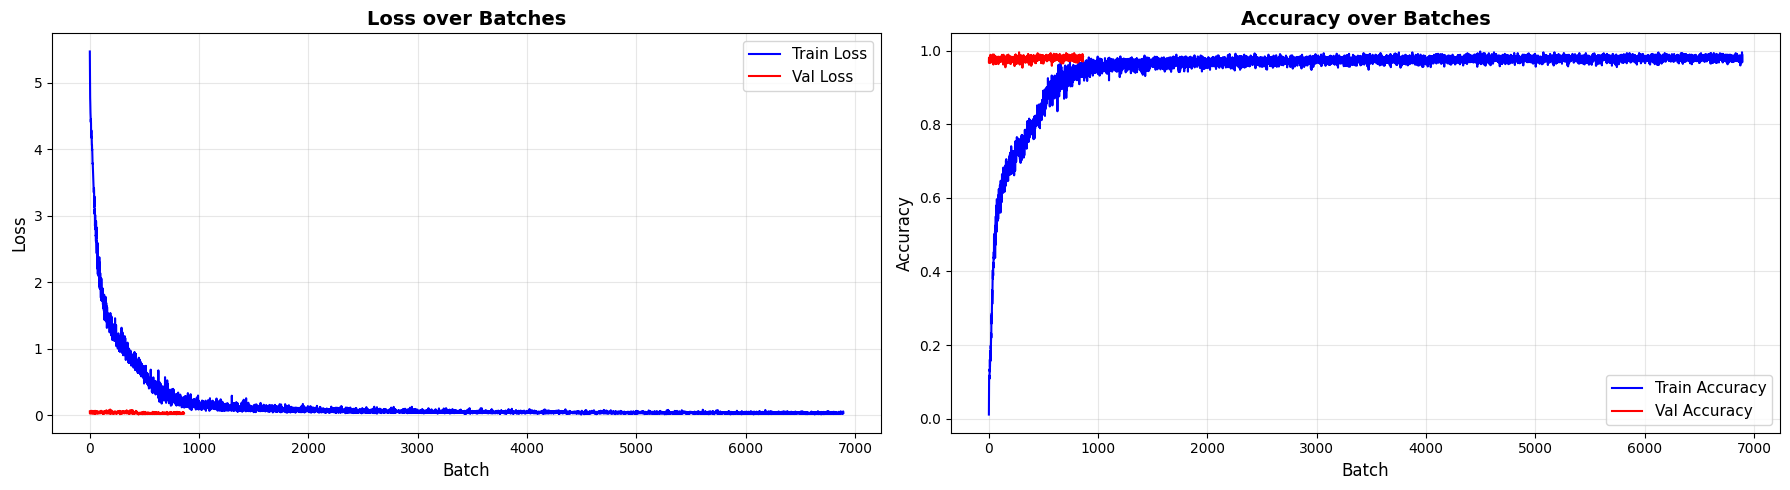

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18,5))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss')
axes[0].plot(history['val_loss'], 'r-', label='Val Loss')
axes[0].set_xlabel('Batch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss over Batches', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train Accuracy')
axes[1].plot(history['val_acc'], 'r-', label='Val Accuracy')
axes[1].set_xlabel('Batch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy over Batches', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Evaluation on test set

In [23]:
def greedy_decode(model, src, max_len, start_symbol):
    model.eval()
    src = src.to(DEVICE)

    # ===== Encoder =====
    src_mask = torch.zeros((src.size(0), src.size(0)), device=DEVICE).bool()
    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1)

    memory = model.transformer.encoder(
        model.positional_encoding(model.src_tok_emb(src)),
        mask=src_mask,
        src_key_padding_mask=src_padding_mask
    )

    batch_size = src.size(1)
    ys = torch.ones(1, batch_size, device=DEVICE).fill_(start_symbol).long()

    for _ in range(max_len - 1):
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(DEVICE)
        tgt_padding_mask = (ys == TRG_PAD_IDX).transpose(0, 1)

        with torch.no_grad():
            out = model.transformer.decoder(
                model.positional_encoding(model.tgt_tok_emb(ys)),
                memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask,
                memory_key_padding_mask=src_padding_mask
            )

        prob = model.generator(out[-1])
        next_word = prob.argmax(dim=-1)

        ys = torch.cat([ys, next_word.unsqueeze(0)], dim=0)

        if (next_word == TRG_EOS_IDX).all():
            break

    return ys

In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import Subset

smoothie = SmoothingFunction().method1
itos = trg_vocab.get_itos()

subset_indices = list(range(50))
test_subset = Subset(test_dataset, subset_indices)

test_loader = DataLoader(test_subset, batch_size=32,
                         shuffle=False, collate_fn=collate_fn)

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                           NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(DEVICE)
model.load_state_dict(torch.load("seq2seq_final.pt"))
model.eval()

max_len = 100  # 最大生成长度
results = []   # 用来存翻译结果和 BLEU

# ===== 新增：用于 token-level accuracy =====
total_bleu = 0
total_samples = 0
correct_tokens = 0  # 新增
total_tokens = 0    # 新增

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Test Set (Autoregressive)"):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # 自回归生成
        generated = greedy_decode(model, src, max_len, TRG_SOS_IDX)

        # 转成 batch first
        pred_tokens_batch = generated.transpose(0, 1).tolist()
        target_tokens_batch = tgt.transpose(0, 1).tolist()

        for src_tensor, pred, ref in zip(src.transpose(0,1).tolist(),
                                         pred_tokens_batch,
                                         target_tokens_batch):

            # 解码源句子
            src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_tensor
                                 if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])

            # 清理预测句子
            pred_clean = []
            for tok in pred:
                if tok == TRG_EOS_IDX:
                    break
                if tok not in {TRG_PAD_IDX, TRG_SOS_IDX}:
                    pred_clean.append(itos[tok])
            pred_text = ' '.join(pred_clean)

            # 清理参考句子
            ref_clean = [itos[tok] for tok in ref
                         if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            ref_text = ' '.join(ref_clean)

            # 计算 BLEU
            if len(ref_clean) > 0 and len(pred_clean) > 0:
                bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie) * 100
                total_bleu += bleu
                total_samples += 1
            else:
                bleu = 0.0

            # ===== 新增：计算 token-level accuracy =====
            min_len = min(len(ref_clean), len(pred_clean))
            correct_tokens += sum(r == p for r, p in zip(ref_clean[:min_len], pred_clean[:min_len]))
            total_tokens += len(ref_clean)

            # 保存结果
            results.append({
                "src_text": src_text,
                "predicted_text": pred_text,
                "tgt_text": ref_text,
                "bleu_score": bleu
            })

# ===== 新增：输出平均指标 =====
avg_test_bleu = (total_bleu / total_samples) if total_samples > 0 else 0
token_accuracy = (correct_tokens / total_tokens * 100) if total_tokens > 0 else 0

print(f"\n📊 Autoregressive Test BLEU: {avg_test_bleu:.2f}")
print(f"📊 Token-level Accuracy: {token_accuracy:.2f}%")

# 查看前 5 条翻译
for i, r in enumerate(results[:5]):
    print(f"Sample {i+1}")
    print(f"  📝 Source:    {r['src_text']}")
    print(f"  🤖 Predicted: {r['predicted_text']}")
    print(f"  ✅ Target:    {r['tgt_text']}")
    print(f"  📊 BLEU:      {r['bleu_score']:.2f}\n")

Test Set (Autoregressive): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


📊 Autoregressive Test BLEU: 89.53
📊 Token-level Accuracy: 97.17%
Sample 1
  📝 Source:    france est doux pendant l' hiver , et il est habituellement chaud en février .
  🤖 Predicted: france is mild during winter , and it is usually warm in february .
  ✅ Target:    france is mild during winter , and it is usually warm in february .
  📊 BLEU:      100.00

Sample 2
  📝 Source:    l' inde est jamais froid en février , et il est relaxant en avril .
  🤖 Predicted: india is never chilly during february , and it is relaxing in april .
  ✅ Target:    india is never cold during february , and it is relaxing in april .
  📊 BLEU:      78.25

Sample 3
  📝 Source:    chine est occupé en septembre , mais il est généralement froid en novembre .
  🤖 Predicted: china is busy during september , but it is usually cold in november .
  ✅ Target:    china is busy during september , but it is usually cold in november .
  📊 BLEU:      100.00

Sample 4
  📝 Source:    vous aimez les mangues , les pommes et les

In [37]:
# 按 BLEU 排序
results_sorted = sorted(results, key=lambda x: x['bleu_score'], reverse=True)

print("🏆 Top 5 Best Translations:")
for r in results_sorted[:5]:
    print(r)

print("\n⚠️ Top 5 Worst Translations:")
for r in results_sorted[-5:]:
    print(r)

🏆 Top 5 Best Translations:
{'src_text': "france est doux pendant l' hiver , et il est habituellement chaud en février .", 'predicted_text': 'france is mild during winter , and it is usually warm in february .', 'tgt_text': 'france is mild during winter , and it is usually warm in february .', 'bleu_score': 100.0}
{'src_text': 'chine est occupé en septembre , mais il est généralement froid en novembre .', 'predicted_text': 'china is busy during september , but it is usually cold in november .', 'tgt_text': 'china is busy during september , but it is usually cold in november .', 'bleu_score': 100.0}
{'src_text': 'vous aimez les mangues , les pommes et les oranges .', 'predicted_text': 'you like mangoes , apples , and oranges.', 'tgt_text': 'you like mangoes , apples , and oranges.', 'bleu_score': 100.0}
{'src_text': 'elle déteste les citrons , les raisins et les bananes .', 'predicted_text': 'she dislikes lemons , grapes , and bananas .', 'tgt_text': 'she dislikes lemons , grapes , and b

### 📊 Test Set Performance Visualization


### Checking on samples from test set

### 🎯 Best and Worst Translations


### 📈 BLEU Score Distribution Analysis


In [26]:
import numpy
print(numpy.__version__)
import portalocker
print(portalocker.__version__)

2.0.2
3.2.0


In [27]:


def beam_search_decode(
    model,
    src,
    max_len,
    start_symbol,
    beam_size=5,
    length_penalty_alpha=0.6
):
    model.eval()
    src = src.to(DEVICE)

    # ===== Encoder =====
    src_mask = torch.zeros((src.size(0), src.size(0)), device=DEVICE).bool()
    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1)

    with torch.no_grad():
        memory = model.transformer.encoder(
            model.positional_encoding(model.src_tok_emb(src)),
            mask=src_mask,
            src_key_padding_mask=src_padding_mask
        )

    batch_size = src.size(1)
    final_outputs = []

    # ===== 对 batch 中每个样本独立 beam =====
    for b in range(batch_size):

        memory_b = memory[:, b:b+1, :]
        src_padding_mask_b = src_padding_mask[b:b+1]

        # beam 存：(sequence, log_prob, finished)
        beams = [
            (torch.tensor([[start_symbol]], device=DEVICE), 0.0, False)
        ]

        for step in range(max_len - 1):

            active_beams = []
            for seq, score, finished in beams:
                if not finished:
                    active_beams.append((seq, score))

            # 如果全部结束
            if len(active_beams) == 0:
                break

            # ===== 拼接当前所有未完成 beam =====
            seqs = torch.cat([seq for seq, _ in active_beams], dim=1)
            scores = torch.tensor(
                [score for _, score in active_beams],
                device=DEVICE
            )

            tgt_mask = generate_square_subsequent_mask(seqs.size(0)).to(DEVICE)

            memory_expand = memory_b.repeat(1, seqs.size(1), 1)
            memory_padding_expand = src_padding_mask_b.repeat(seqs.size(1), 1)

            with torch.no_grad():
                out = model.transformer.decoder(
                    model.positional_encoding(model.tgt_tok_emb(seqs)),
                    memory_expand,
                    tgt_mask=tgt_mask,
                    memory_key_padding_mask=memory_padding_expand
                )

                logits = model.generator(out[-1])  # (beam_active, vocab)
                log_probs = torch.log_softmax(logits, dim=-1)

            total_scores = log_probs + scores.unsqueeze(1)

            vocab_size = log_probs.size(-1)
            flat_scores = total_scores.view(-1)

            topk_scores, topk_indices = torch.topk(
                flat_scores,
                min(beam_size, flat_scores.size(0))
            )

            beam_indices = topk_indices // vocab_size
            token_indices = topk_indices % vocab_size

            # ===== 构造新 beams =====
            new_beams = []

            # 先把已完成的保留下来（不扩展）
            for seq, score, finished in beams:
                if finished:
                    new_beams.append((seq, score, True))

            for i in range(topk_scores.size(0)):
                beam_idx = beam_indices[i].item()
                token_idx = token_indices[i].item()

                seq, prev_score = active_beams[beam_idx]

                new_seq = torch.cat(
                    [seq, torch.tensor([[token_idx]], device=DEVICE)],
                    dim=0
                )

                new_score = topk_scores[i].item()
                finished = (token_idx == TRG_EOS_IDX)

                new_beams.append((new_seq, new_score, finished))

            # 重新选 beam_size 个
            def length_penalty(score, length):
                return score / ((5 + length) / 6) ** length_penalty_alpha

            new_beams = sorted(
                new_beams,
                key=lambda x: length_penalty(x[1], x[0].size(0)),
                reverse=True
            )[:beam_size]

            beams = new_beams

        # ===== 选最优 =====
        def length_penalty(score, length):
            return score / ((5 + length) / 6) ** length_penalty_alpha

        beams = sorted(
            beams,
            key=lambda x: length_penalty(x[1], x[0].size(0)),
            reverse=True
        )

        best_seq = beams[0][0].squeeze(1)
        final_outputs.append(best_seq)

    # ===== pad batch 输出 =====
    return torch.nn.utils.rnn.pad_sequence(final_outputs)

In [34]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import Subset

smoothie = SmoothingFunction().method1
itos = trg_vocab.get_itos()

subset_indices = list(range(50))
test_subset = Subset(test_dataset, subset_indices)

test_loader = DataLoader(test_subset, batch_size=32,
                         shuffle=False, collate_fn=collate_fn)

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                           NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(DEVICE)
model.load_state_dict(torch.load("seq2seq_final.pt"))
model.eval()

max_len = 100  # 最大生成长度
results = []   # 用来存翻译结果和 BLEU

# ===== 新增：用于 token-level accuracy =====
total_bleu = 0
total_samples = 0
correct_tokens = 0  # 新增
total_tokens = 0    # 新增

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Test Set (Autoregressive)"):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # 自回归生成
        generated = beam_search_decode(model, src, max_len, TRG_SOS_IDX)

        # 转成 batch first
        pred_tokens_batch = generated.transpose(0, 1).tolist()
        target_tokens_batch = tgt.transpose(0, 1).tolist()

        for src_tensor, pred, ref in zip(src.transpose(0,1).tolist(),
                                         pred_tokens_batch,
                                         target_tokens_batch):

            # 解码源句子
            src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_tensor
                                 if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])

            # 清理预测句子
            pred_clean = []
            for tok in pred:
                if tok == TRG_EOS_IDX:
                    break
                if tok not in {TRG_PAD_IDX, TRG_SOS_IDX}:
                    pred_clean.append(itos[tok])
            pred_text = ' '.join(pred_clean)

            # 清理参考句子
            ref_clean = [itos[tok] for tok in ref
                         if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            ref_text = ' '.join(ref_clean)

            # 计算 BLEU
            if len(ref_clean) > 0 and len(pred_clean) > 0:
                bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie) * 100
                total_bleu += bleu
                total_samples += 1
            else:
                bleu = 0.0

            # ===== 新增：计算 token-level accuracy =====
            min_len = min(len(ref_clean), len(pred_clean))
            correct_tokens += sum(r == p for r, p in zip(ref_clean[:min_len], pred_clean[:min_len]))
            total_tokens += len(ref_clean)

            # 保存结果
            results.append({
                "src_text": src_text,
                "predicted_text": pred_text,
                "tgt_text": ref_text,
                "bleu_score": bleu
            })

# ===== 新增：输出平均指标 =====
avg_test_bleu = (total_bleu / total_samples) if total_samples > 0 else 0
token_accuracy = (correct_tokens / total_tokens * 100) if total_tokens > 0 else 0

print(f"\n📊 Autoregressive Test BLEU: {avg_test_bleu:.2f}")
print(f"📊 Token-level Accuracy: {token_accuracy:.2f}%")

# 查看前 5 条翻译
for i, r in enumerate(results[:5]):
    print(f"Sample {i+1}")
    print(f"  📝 Source:    {r['src_text']}")
    print(f"  🤖 Predicted: {r['predicted_text']}")
    print(f"  ✅ Target:    {r['tgt_text']}")
    print(f"  📊 BLEU:      {r['bleu_score']:.2f}\n")

Test Set (Autoregressive): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


📊 Autoregressive Test BLEU: 90.13
📊 Token-level Accuracy: 97.32%
Sample 1
  📝 Source:    france est doux pendant l' hiver , et il est habituellement chaud en février .
  🤖 Predicted: france is mild during winter , and it is usually warm in february .
  ✅ Target:    france is mild during winter , and it is usually warm in february .
  📊 BLEU:      100.00

Sample 2
  📝 Source:    l' inde est jamais froid en février , et il est relaxant en avril .
  🤖 Predicted: india is never chilly during february , and it is relaxing in april .
  ✅ Target:    india is never cold during february , and it is relaxing in april .
  📊 BLEU:      78.25

Sample 3
  📝 Source:    chine est occupé en septembre , mais il est généralement froid en novembre .
  🤖 Predicted: china is busy during september , but it is usually cold in november .
  ✅ Target:    china is busy during september , but it is usually cold in november .
  📊 BLEU:      100.00

Sample 4
  📝 Source:    vous aimez les mangues , les pommes et les

In [35]:
# 按 BLEU 排序
results_sorted = sorted(results, key=lambda x: x['bleu_score'], reverse=True)

print("🏆 Top 5 Best Translations:")
for r in results_sorted[:5]:
    print(r)

print("\n⚠️ Top 5 Worst Translations:")
for r in results_sorted[-5:]:
    print(r)

🏆 Top 5 Best Translations:
{'src_text': "france est doux pendant l' hiver , et il est habituellement chaud en février .", 'predicted_text': 'france is mild during winter , and it is usually warm in february .', 'tgt_text': 'france is mild during winter , and it is usually warm in february .', 'bleu_score': 100.0}
{'src_text': 'chine est occupé en septembre , mais il est généralement froid en novembre .', 'predicted_text': 'china is busy during september , but it is usually cold in november .', 'tgt_text': 'china is busy during september , but it is usually cold in november .', 'bleu_score': 100.0}
{'src_text': 'vous aimez les mangues , les pommes et les oranges .', 'predicted_text': 'you like mangoes , apples , and oranges.', 'tgt_text': 'you like mangoes , apples , and oranges.', 'bleu_score': 100.0}
{'src_text': 'elle déteste les citrons , les raisins et les bananes .', 'predicted_text': 'she dislikes lemons , grapes , and bananas .', 'tgt_text': 'she dislikes lemons , grapes , and b

####
To-Do

Q. Visualize results for other samples from the test set

Q. Try different epoch values — e.g., 4, 5, 6 — and observe how the loss changes.

Q. Experiment with different architecture configurations, such as changing the number of encoder and decoder layers.

Q. Try for different batch sizes

Q. We you find a different translation dataset try on that.

### Resources

[The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)


### [Quiz](https://docs.google.com/forms/d/e/1FAIpQLScM0wn9cLVWCQvJemeOWlrK_RhGBmdeKOJBaqFkERFGmyqK3w/viewform?usp=dialog)

Changes:
1. translate from French to English
2. test: autoregressive generation -- time+3min
3. epoch=2




Exercises:
1. loss/accuracy curve
2. checking the test bleu_score and samples
3. greedy decode vs beam search -- performance improve a little




Cannot:
1. batch_size num_hidden -- performance didn't change
